# Imports

In [1]:
!pip install sklearn --upgrade

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os 

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, RidgeClassifier, RidgeClassifierCV

# Loading data

In [55]:
employee = pd.read_csv('C:/py/data/attrition/employee_process.csv')

In [56]:
y=employee['y']
X=employee.drop(columns=['y'])

## Add only cross-products

In [57]:
augmentation =[ ]
for var in X.columns :
    if X[var].unique().tolist() == [0,1] :
        pass
    elif X[var].unique().tolist() ==[1,0]:
        pass
    else :
        augmentation.append(var)

In [58]:
for var in augmentation :
    
    X[var+'_squared'] = X[var]**2
    X[var+'_cube'] = X[var]**3

In [59]:
for i in range(len(augmentation)-1):
     X[augmentation[i]+'_'+augmentation[i+1]] = X[augmentation[i]]*X[augmentation[i+1]]

### Split into train and test subsample

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1176, 117)
(1176,)
(294, 117)
(294,)


In [9]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Defition of the metrics function 

In [122]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [12]:
def recall_precision(y_test,y_pred,model):
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    fscore[np.isnan(fscore)] = 0
    #print(fscore)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    optimal_threshold = thresholds[ix]

    # plot the recall precision curve for the model
    plt.plot(recall, precision, marker='.', label=model)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()
    
    print("\nTEST")
    print('Best Threshold=%f, F-Score=%.3f' % (optimal_threshold, fscore[ix]))
    y_pred2= np.where(y_pred <= optimal_threshold , 0, 1)
    cm = confusion_matrix(y_test, y_pred2)
    print("Confusion matrix \n" , cm)
    precision = cm[1,1]/sum(cm[:,1])
    print("\nPrecision : " + str(precision))
    recall = cm[1,1]/sum(cm[1,:])
    print("Recall : " + str(recall))
    f1 = 2*((precision*recall)/(precision+recall))
    print("F1 : " + str(f1))
    
    residual = (y_test - y_pred)
    print("\n Residuals distribution : \n", residual.describe())
    
    return optimal_threshold

# OLS

In [117]:
model = LinearRegression().fit(X_train, y_train)
y_ols = model.predict(X_test)

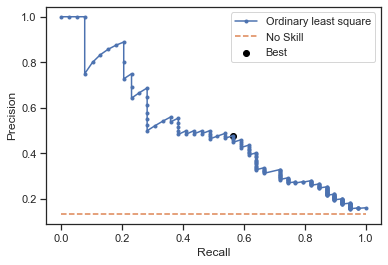


TEST
Best Threshold=0.414307, F-Score=0.518
Confusion matrix 
 [[231  24]
 [ 18  21]]

Precision : 0.4666666666666667
Recall : 0.5384615384615384
F1 : 0.5

 Residuals distribution : 
 count    294.000000
mean      -0.032658
std        0.322090
min       -0.644775
25%       -0.243958
50%       -0.079956
75%        0.077576
max        1.042236
Name: y, dtype: float64


In [118]:
Tols = recall_precision(y_test,y_ols,'Ordinary least square')

In [119]:
y_ols2= np.where(y_ols <= Tols , 0, 1)

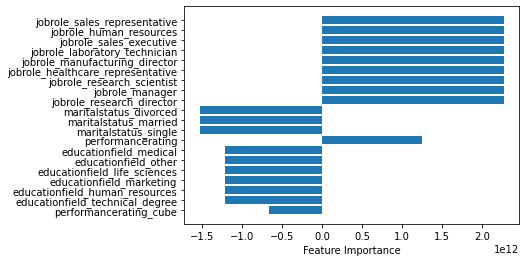

In [29]:
sort = abs(model.coef_).argsort()
sort = sort[-20:]
plt.barh(X.columns[sort], model.coef_[sort])
plt.xlabel("Feature Importance")
plt.show()

# Logistic regression

In [30]:
clf = LogisticRegression().fit(X_train, y_train)
y_log = clf.predict_proba(X_test)[:,1]

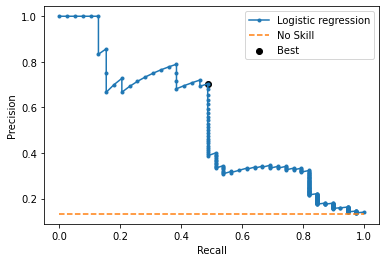


TEST
Best Threshold=0.489009, F-Score=0.576
Confusion matrix 
 [[247   8]
 [ 21  18]]

Precision : 0.6923076923076923
Recall : 0.46153846153846156
F1 : 0.553846153846154

 Residuals distribution : 
 count    294.000000
mean      -0.018875
std        0.300702
min       -0.716322
25%       -0.123113
50%       -0.047872
75%       -0.009622
max        0.996411
Name: y, dtype: float64


0.489009463805018

In [31]:
recall_precision(y_test,y_log,'Logistic regression')

In [32]:
y_log2 = np.where(y_log <= 0.489009 , 0, 1)

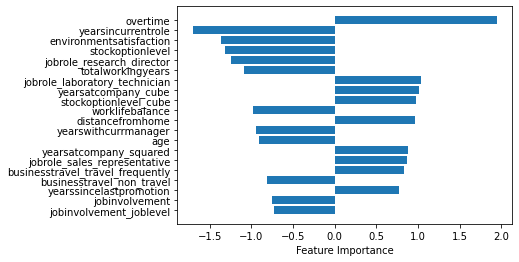

In [49]:
sort = abs(clf.coef_[0]).argsort()
sort = sort[-20:]
plt.barh(X.columns[sort], clf.coef_[0][sort])
plt.xlabel("Feature Importance")
plt.show()

# Ridge

In [36]:
alphas = 10**np.linspace(5,0,1000)*0.5

In [69]:
# Found the alpha
ridgecv = RidgeCV(alphas = alphas,
                  cv=10,
                  scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train, y_train)
print("The optimal alpha seems to be :",round(ridgecv.alpha_,4))
# Train the model
Rclf = Ridge(alpha = ridgecv.alpha_)
trained_Rclf = Rclf.fit(X_train,y_train)
# Prediction
y_ridge = trained_Rclf.predict(X_test)

The optimal alpha seems to be : 2.51


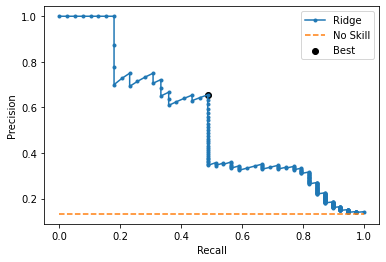


TEST
Best Threshold=0.423961, F-Score=0.559
Confusion matrix 
 [[245  10]
 [ 21  18]]

Precision : 0.6428571428571429
Recall : 0.46153846153846156
F1 : 0.537313432835821

 Residuals distribution : 
 count    294.000000
mean      -0.027253
std        0.318429
min       -0.535504
25%       -0.208166
50%       -0.108391
75%        0.072875
max        1.135069
Name: y, dtype: float64


In [71]:
Tridge = recall_precision(y_test,y_ridge,'Ridge')

In [115]:
y_ridge2 = np.where(y_ridge <= Tridge , 0, 1)

In [133]:
print('The automatic selection method Ridge selected', sum(lasso.coef_ > 0.01), 'variables in a pool of 117.')

The automatic selection method Ridge selected 28 variables in a pool of 117.


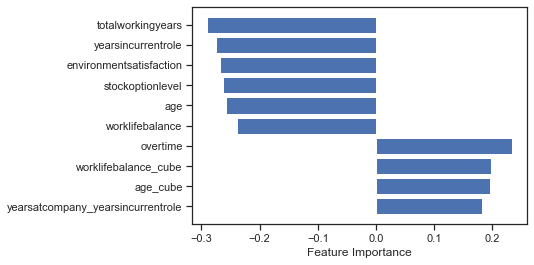

In [142]:
sort = abs(Rclf.coef_).argsort()
sort = sort[-10:]
plt.barh(X.columns[sort], Rclf.coef_[sort])
plt.xlabel("Feature Importance")
plt.show()

In [154]:
sort_ = abs(Rclf.coef_).argsort()
sort_ = sort_[-28:]
selection = pd.DataFrame({
    'Variables' : X.columns[sort_],
    'Coefficient' : Rclf.coef_[sort_]

})
selection['trie'] = abs(selection['Coefficient'])
selection = selection.sort_values(by=['trie'],ascending=False)
selection = selection.drop(columns=['trie'])
selection

,Variables,Coefficient
27,totalworkingyears,-0.289417
26,yearsincurrentrole,-0.275160
25,environmentsatisfaction,-0.268094
24,stockoptionlevel,-0.263477
23,age,-0.256816
22,worklifebalance,-0.238431
21,overtime,0.233113
20,worklifebalance_cube,0.196617
19,age_cube,0.195085
18,yearsatcompany_yearsincurrentrole,0.181206


In [82]:
#lassocv = LassoCV(alphas = alphas,cv= 10)
lassocv = LassoCV(alphas = None,
                  cv = 10, 
                  random_state = 0,
                  max_iter = 10000)
lassocv.fit(X_train, y_train)
# Optimal alpha
print("The optimal alpha seems to be : ", round(lassocv.alpha_,4))

C:\Users\Bruguet\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015496947839736208, tolerance: 0.014805293005671075
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Bruguet\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01495804086505359, tolerance: 0.014805293005671075
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Bruguet\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015276478569091978, tolerance: 0.014805293005671075
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Bruguet\anaconda3\lib\site-packages\sklearn\linear_model\_coor

The optimal alpha seems to be :  0.0004


In [83]:
lasso = Lasso(max_iter = 100000)
# Train the model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
# Prediction
y_lasso = lasso.predict(X_test)

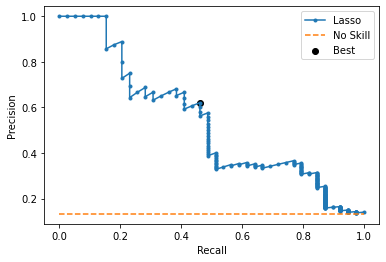


TEST
Best Threshold=0.418116, F-Score=0.529
Confusion matrix 
 [[244  11]
 [ 22  17]]

Precision : 0.6071428571428571
Recall : 0.4358974358974359
F1 : 0.5074626865671643

 Residuals distribution : 
 count    294.000000
mean      -0.025579
std        0.317355
min       -0.544476
25%       -0.204239
50%       -0.104943
75%        0.067858
max        1.135510
Name: y, dtype: float64


In [84]:
Tlasso = recall_precision(y_test,y_lasso,'Lasso')

In [116]:
y_lasso2 = np.where(y_lasso <= Tlasso , 0, 1)

In [135]:
print('The automatic selection method lasso selected', sum(lasso.coef_ > 0.01), 'variables in a pool of 117.')

The automatic selection method lasso selected 28 variables in a pool of 117.


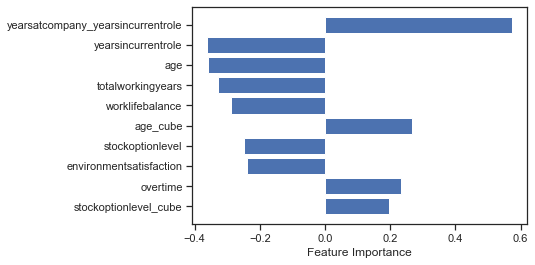

In [155]:
sort = abs(lasso.coef_).argsort()
sort = sort[-10:]
plt.barh(X.columns[sort], lasso.coef_[sort])
plt.xlabel("Feature Importance")
plt.show()

In [156]:
sort_ = abs(lasso.coef_).argsort()
sort_ = sort_[-28:]
selection = pd.DataFrame({
    'Variables' : X.columns[sort_],
    'Coefficient' : lasso.coef_[sort_]
})

selection['trie'] = abs(selection['Coefficient'])
selection = selection.sort_values(by=['trie'],ascending=False)
selection = selection.drop(columns=['trie'])
selection

,Variables,Coefficient
27,yearsatcompany_yearsincurrentrole,0.572857
26,yearsincurrentrole,-0.361018
25,age,-0.358545
24,totalworkingyears,-0.328713
23,worklifebalance,-0.289403
22,age_cube,0.266610
21,stockoptionlevel,-0.248308
20,environmentsatisfaction,-0.239606
19,overtime,0.232411
18,stockoptionlevel_cube,0.196944


# Model comparaisons

## Residuals analysis

C:\Users\Bruguet\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Bruguet\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Bruguet\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

Text(0.5, 1.0, 'Residuals distribution')

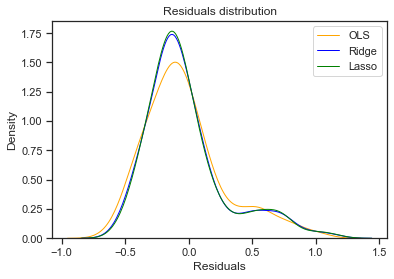

In [97]:
sns.set(style="ticks", color_codes=True)
sns.distplot((y_test-y_ols), hist=False, kde=True, kde_kws = {'shade': False, 'linewidth' : 1},
             bins=50, color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((y_test-y_ridge), hist=False, kde=True, kde_kws = {'shade': False, 'linewidth' : 1},
             bins=50, color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((y_test-y_lasso), hist=False, kde=True, kde_kws = {'shade': False, 'linewidth' : 1},
             bins=50, color = 'green',
             hist_kws={'edgecolor':'black'})
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend(labels=["OLS","Ridge", "Lasso"])
plt.title('Residuals distribution')

### Using PrecisionRecallDisplay.**from_estimators**

In [98]:
def recall (y_test,y_pred,model) :
    
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    # plot the roc curve for the model
    recall_plot = plt.plot(recall, precision, marker='.', label=model)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(bbox_to_anchor=(0.5, -0.4), loc='center', ncol=1)
    # show the plot
    return(recall_plot)

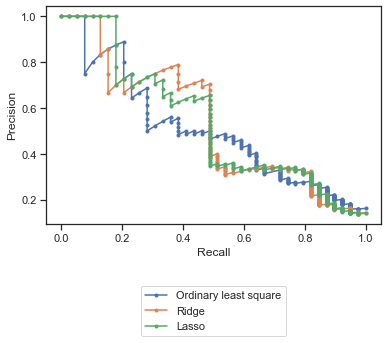

In [99]:
recall_ols = recall(y_test,y_ols, 'Ordinary least square')
recall_rige = recall(y_test,y_log, 'Ridge')
recall_lasso = recall(y_test,y_ridge,'Lasso')

In [123]:
 f_score = pd.DataFrame({
    'Algorithm' : ['OLS','Ridge','Lasso'],
    'y_pred' : [y_ols2,y_ridge2,y_lasso2]
})
f1_list = []
for index, row in f_score.iterrows():
    f1 = f1_score(y_test, row['y_pred'], average='binary')
    f1_list.append(f1)
acc_list = []
for index, row in f_score.iterrows():
    acc = accuracy_score(y_test, row['y_pred'])
    acc_list.append(acc)
    
f_score['f1']=f1_list
f_score['acc']=acc_list
f_score = f_score.drop(['y_pred'], axis=1)
f_score.sort_values(by=['f1'],ascending=False)

,Algorithm,f1,acc
1,Ridge,0.537313,0.894558
2,Lasso,0.507463,0.887755
0,OLS,0.500000,0.857143
